# Workshop 2: Quality Control (QC)
Preparing and filtering data for genome-wide association studies.

> Kostas Hatzikotoulas (hatzikotoulas@helmholtz-muenchen.de)

> Xenofon Giannoulis (xenofon.giannoulis@helmholtz-muenche.de)

# Objectives

In this workshop, you will learn the data quality assessment and control steps that are typically carried out during genome wide association studies (GWAS).

## Prerequisites
For this practical workshop, we need the following software:
- [PLINK](https://www.cog-genomics.org/plink/) for data management
- [R](https://www.r-project.org/) for visualization of different QC measures



## Distinguish R Python and Bash Shells

> Since this a python configured notebook, we import the basic packages to intergrate bash and R. Please make sure that you notice the following differences:

- when a command starts with `!`, this is a linux command writen in bash (for managing directories and executing plink commands)

- when a shell starts with `%%R` the code follows is written in R


## Why do we need the QC?

Study design and errors in genotype calling can introduce systematic biases into GWAS, leading to spurious associations. A thorough QC can help us identify samples and markers that should be removed prior to association analysis in order to minimize the number of false-positive and false-negative associations.

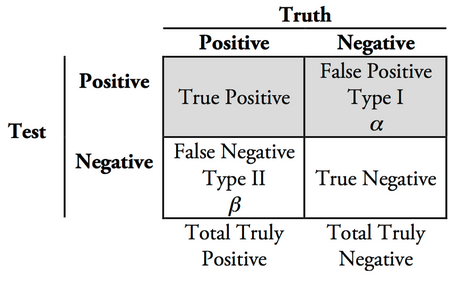

In this tutorial, we assume that the study design has been conducted appropriately and the QC applies to the genotypes after they have been called from probe intensity data. 

QC protocol The QC protocol of a GWAS is usually split into two broad categories, ***Sample QC*** and ***Variant QC***. 

Sample QC is done prior to Variant QC because we want to maximise the number of markers remaining in the study.

## Sample QC

It consists of (at least) five steps:

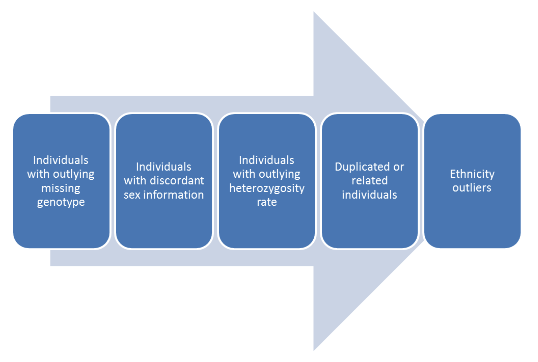

# Data, Directories & Libraries


## Google Drive

Let us set up the connection with Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We set up the file paths to the respective directories.

In [2]:
# this is the file path to your google drive (/content/drive/My Drive/) followed up by the data path
dir_path='/content/drive/My Drive/Complex_Traits/2_Workshop_Quality_Control/data/' 
dir_scripts="/content/drive/My Drive/Complex_Traits/2_Workshop_Quality_Control/scripts/"


## Packages

Install the rpy2 package that allows us to run R from a python notebook

In [3]:
!pip install rpy2==3.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 158 kB 21.5 MB/s 
  Created wheel for rpy2: filename=rpy2-3.1.0-py3-none-any.whl size=169548 sha256=c7c68e9a76bf80ee9ea649b26fb48822b3de335b55483264933d818a8dc341c5
  Stored in directory: /root/.cache/pip/wheels/82/f2/08/1067ab99f54791b649b977e610b05d7c81946bd4e48dcb15a2
  Created wheel for simplegeneric: filename=simplegeneric-0.8.1-py3-none-any.whl size=5078 sha256=ee22e5f62760fed55059a10ea4af5deda90208f138b2650eac82d976ee64d200
  Stored in directory: /root/.cache/pip/wheels/90/de/df/f1324f4dd966636ab877b82d467acad38a0998b1c42ddb7288
Successfully built rpy2 simplegeneric
  Attempting uninstall: rpy2
    Found existing installation: rpy2 3.5.5
    Uninstalling rpy2-3.5.5:
      Successfully uninstalled rpy2-3.5.5


Import necessary libraries

In [4]:
import os # python related package to list files in the defined directory
import rpy2.ipython 
%load_ext rpy2.ipython

/usr/local/lib/python3.7/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [5]:
%%R 
dir_path = '/content/drive/My Drive/Complex_Traits/2_Workshop_Quality_Control/data'
setwd(paste0(dir_path))

Check the contents of the current path

In [6]:
os.listdir(dir_path)

['cluster_sep_scr_to-exclude.txt',
 'VSS-1Kg.bed',
 'VSS-1Kg.bim',
 'VSS-1Kg.fam',
 'Final_exclusionlist.txt',
 'complex.regions.txt',
 'Populationfile-1kg.txt',
 'Populationfile-1kg_rmoutliers.txt',
 'VSS.log',
 'VSS.fam',
 'VSS.bim',
 'VSS.bed']

In [7]:
sorted(os.listdir(dir_path))

['Final_exclusionlist.txt',
 'Populationfile-1kg.txt',
 'Populationfile-1kg_rmoutliers.txt',
 'VSS-1Kg.bed',
 'VSS-1Kg.bim',
 'VSS-1Kg.fam',
 'VSS.bed',
 'VSS.bim',
 'VSS.fam',
 'VSS.log',
 'cluster_sep_scr_to-exclude.txt',
 'complex.regions.txt']

In [8]:
os.listdir(dir_scripts)

['ExcludeIDsonIBD.r', 'space_to_tab.pl', 'calc_het_v2.pl']

## If Linux/Windows/Mac

If working on your local machine, or a remote server environment you will want to start any project by creating and defining your working directory in a variable name, such as:
```
mkdir your_directory_name 
```
- where `your_directory_name` can be named as `QC`

```
DIR="path_to/your_directory_name"
```

- where `path_to` represents the directory until the folder we have just created
- `DIR` represents the variable where we store the complete path for the analysis (i.e `DIR=~/QC`)

In our case, we are using this notebook where no terminal is needed for execution of any commands, but there is a virtual directory for each user where we can download the data from github using `wget`, and run plink sofware with `!./plink`


## Downloading PLINK software

In [9]:
!wget https://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20210606.zip && unzip plink_linux_x86_64_20210606.zip && rm prettify toy.* LICENSE
!rm *.zip

--2022-11-15 12:00:42--  https://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20210606.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 3.5.1.157
Connecting to s3.amazonaws.com (s3.amazonaws.com)|3.5.1.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8917076 (8.5M) [application/zip]
Saving to: ‘plink_linux_x86_64_20210606.zip’

plink_linux_x86_64_ 100%[===================>]   8.50M  41.2MB/s    in 0.2s    

2022-11-15 12:00:43 (41.2 MB/s) - ‘plink_linux_x86_64_20210606.zip’ saved [8917076/8917076]

Archive:  plink_linux_x86_64_20210606.zip
  inflating: plink                   
  inflating: LICENSE                 
  inflating: toy.ped                 
  inflating: toy.map                 
  inflating: prettify                


- Quickly test that plink sofware command is executable on bash
> you should be able to see all available flags (options) plink has for data processing.

In [10]:
!./plink

PLINK v1.90b6.24 64-bit (6 Jun 2021)           www.cog-genomics.org/plink/1.9/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3

  plink <input flag(s)...> [command flag(s)...] [other flag(s)...]
  plink --help [flag name(s)...]

Commands include --make-bed, --recode, --flip-scan, --merge-list,
--write-snplist, --list-duplicate-vars, --freqx, --missing, --test-mishap,
--hardy, --mendel, --ibc, --impute-sex, --indep-pairphase, --r2, --show-tags,
--blocks, --distance, --genome, --homozyg, --make-rel, --make-grm-gz,
--rel-cutoff, --cluster, --pca, --neighbour, --ibs-test, --regress-distance,
--model, --bd, --gxe, --logistic, --dosage, --lasso, --test-missing,
--make-perm-pheno, --tdt, --qfam, --annotate, --clump, --gene-report,
--meta-analysis, --epistasis, --fast-epistasis, and --score.

"plink --help | more" describes all functions (warning: long).


## Basic Plink Commands

### Step 1: Remove Individuals with outlying missing genotype 

In [ ]:
# ignore this cell, can be used only if you cannot download the data and the drive ~ if connection is not working
#!wget -O data https://ascgitlab.helmholtz-muenchen.de/xenofon.giannoulis/VolosSummerSchool/-/tree/master/VSS_2019/Workshop2_QC

In [11]:
# define th file we will be working on:
FILE="VSS"

In [12]:
# 1.1 Generate a list genotyping/missingness rate statistics
!./plink --bfile $FILE --missing --out $FILE-missing

PLINK v1.90b6.24 64-bit (6 Jun 2021)           www.cog-genomics.org/plink/1.9/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to VSS-missing.log.
Options in effect:
  --bfile VSS
  --missing
  --out VSS-missing

12985 MB RAM detected; reserving 6492 MB for main workspace.
426901 variants loaded from .bim file.
538 people (255 males, 283 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 538 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%56%57%58%59%60%61%62%63%64%65%66%67%68%69%70%71%72%73%74%75%

In [13]:
# 1.2 Produce a log file giving samples excluded at Call Rate 0.98 to check against R result 

# removing individuals with high missing genotype rates

!./plink --bfile $FILE --mind 0.02 --make-bed --out $FILE-mind0.02


PLINK v1.90b6.24 64-bit (6 Jun 2021)           www.cog-genomics.org/plink/1.9/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to VSS-mind0.02.log.
Options in effect:
  --bfile VSS
  --make-bed
  --mind 0.02
  --out VSS-mind0.02

12985 MB RAM detected; reserving 6492 MB for main workspace.
426901 variants loaded from .bim file.
538 people (255 males, 283 females) loaded from .fam.
14 people removed due to missing genotype data (--mind).
IDs written to VSS-mind0.02.irem .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 524 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%56%57%

### Step 2: Individuals with discordant sex information

In [ ]:
# 2.1 Run sex checking

# use !./plink to run sex check and export your cleaned file as $FILE-sexcheck



In [14]:
#@title solution
# 2.1 Run sex checking

!./plink --bfile $FILE --check-sex --out $FILE-sexcheck


PLINK v1.90b6.24 64-bit (6 Jun 2021)           www.cog-genomics.org/plink/1.9/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to VSS-sexcheck.log.
Options in effect:
  --bfile VSS
  --check-sex
  --out VSS-sexcheck

12985 MB RAM detected; reserving 6492 MB for main workspace.
426901 variants loaded from .bim file.
538 people (255 males, 283 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 538 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%56%57%58%59%60%61%62%63%64%65%66%67%68%69%70%71%72%73%74%7

In [ ]:
# 2.2 Extract xchr SNPs

# use !./plink to Extract xchr SNPs and export your cleaned file as $FILE-xchr




In [17]:
!./plink --bfile $FILE --chr 23 --make-bed --out $FILE-xchr

PLINK v1.90b6.24 64-bit (6 Jun 2021)           www.cog-genomics.org/plink/1.9/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to VSS-xchr.log.
Options in effect:
  --bfile VSS
  --chr 23
  --make-bed
  --out VSS-xchr

12985 MB RAM detected; reserving 6492 MB for main workspace.
10465 out of 426901 variants loaded from .bim file.
538 people (255 males, 283 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 538 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%56%57%58%59%60%61%62%63%64%65%66%67%68%69%70%71%72%

In [ ]:
#@title Solution
# 2.2 Extract xchr SNPs

!./plink --bfile $FILE --chr 23 --make-bed --out $FILE-xchr


In [19]:
!ls

cluster_sep_scr_to-exclude.txt	   VSS-1Kg.bed	      VSS-missing.imiss
complex.regions.txt		   VSS-1Kg.bim	      VSS-missing.lmiss
Final_exclusionlist.txt		   VSS-1Kg.fam	      VSS-missing.log
plink				   VSS.bed	      VSS-sexcheck.hh
plink.bed			   VSS.bim	      VSS-sexcheck.log
plink.bim			   VSS.fam	      VSS-sexcheck.sexcheck
plink.fam			   VSS.log	      VSS-xchr.bed
plink.hh			   VSS-mind0.02.bed   VSS-xchr.bim
plink.imiss			   VSS-mind0.02.bim   VSS-xchr.fam
plink.lmiss			   VSS-mind0.02.fam   VSS-xchr.hh
plink.log			   VSS-mind0.02.irem  VSS-xchr.log
Populationfile-1kg_rmoutliers.txt  VSS-mind0.02.log
Populationfile-1kg.txt		   VSS-missing.hh


In [20]:
# 2.3 Run missingness on xchr SNPs

# use !./plink to Run missingness on xchr SNPs and export your cleaned file as $FILE-xchr-missing

!./plink --bfile $FILE-xchr --missing --make-bed --out $FILE-xchr-missing


PLINK v1.90b6.24 64-bit (6 Jun 2021)           www.cog-genomics.org/plink/1.9/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to VSS-xchr-missing.log.
Options in effect:
  --bfile VSS-xchr
  --make-bed
  --missing
  --out VSS-xchr-missing

12985 MB RAM detected; reserving 6492 MB for main workspace.
10465 variants loaded from .bim file.
538 people (255 males, 283 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 538 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%56%57%58%59%60%61%62%63%64%65%66%67%68%69%70%71

In [21]:
!ls

cluster_sep_scr_to-exclude.txt	   VSS-1Kg.fam	      VSS-sexcheck.log
complex.regions.txt		   VSS.bed	      VSS-sexcheck.sexcheck
Final_exclusionlist.txt		   VSS.bim	      VSS-xchr.bed
plink				   VSS.fam	      VSS-xchr.bim
plink.bed			   VSS.log	      VSS-xchr.fam
plink.bim			   VSS-mind0.02.bed   VSS-xchr.hh
plink.fam			   VSS-mind0.02.bim   VSS-xchr.log
plink.hh			   VSS-mind0.02.fam   VSS-xchr-missing.bed
plink.imiss			   VSS-mind0.02.irem  VSS-xchr-missing.bim
plink.lmiss			   VSS-mind0.02.log   VSS-xchr-missing.fam
plink.log			   VSS-missing.hh     VSS-xchr-missing.hh
Populationfile-1kg_rmoutliers.txt  VSS-missing.imiss  VSS-xchr-missing.imiss
Populationfile-1kg.txt		   VSS-missing.lmiss  VSS-xchr-missing.lmiss
VSS-1Kg.bed			   VSS-missing.log    VSS-xchr-missing.log
VSS-1Kg.bim			   VSS-sexcheck.hh


In [ ]:
#@title Solution
# 2.3 Run missingness on xchr SNPs

!./plink --bfile $FILE-xchr --missing --out $FILE-xchr-missing


### Step_3: Individuals with outlying heterozygosity rate


In [22]:
# 3.1 Extract autosomal SNPs

# use !./plink to Extract autosomal SNPs from $FILE and export your cleaned file as $FILE-chr1-22
!./plink --bfile $FILE --autosome --make-bed --out $FILE-chr1-22


PLINK v1.90b6.24 64-bit (6 Jun 2021)           www.cog-genomics.org/plink/1.9/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to VSS-chr1-22.log.
Options in effect:
  --autosome
  --bfile VSS
  --make-bed
  --out VSS-chr1-22

12985 MB RAM detected; reserving 6492 MB for main workspace.
416436 out of 426901 variants loaded from .bim file.
538 people (255 males, 283 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 538 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%56%57%58%59%60%61%62%63%64%65%66%67%68%69%70%7

In [23]:
!ls

cluster_sep_scr_to-exclude.txt	   VSS.bed	      VSS-missing.log
complex.regions.txt		   VSS.bim	      VSS-sexcheck.hh
Final_exclusionlist.txt		   VSS-chr1-22.bed    VSS-sexcheck.log
plink				   VSS-chr1-22.bim    VSS-sexcheck.sexcheck
plink.bed			   VSS-chr1-22.fam    VSS-xchr.bed
plink.bim			   VSS-chr1-22.log    VSS-xchr.bim
plink.fam			   VSS.fam	      VSS-xchr.fam
plink.hh			   VSS.log	      VSS-xchr.hh
plink.imiss			   VSS-mind0.02.bed   VSS-xchr.log
plink.lmiss			   VSS-mind0.02.bim   VSS-xchr-missing.bed
plink.log			   VSS-mind0.02.fam   VSS-xchr-missing.bim
Populationfile-1kg_rmoutliers.txt  VSS-mind0.02.irem  VSS-xchr-missing.fam
Populationfile-1kg.txt		   VSS-mind0.02.log   VSS-xchr-missing.hh
VSS-1Kg.bed			   VSS-missing.hh     VSS-xchr-missing.imiss
VSS-1Kg.bim			   VSS-missing.imiss  VSS-xchr-missing.lmiss
VSS-1Kg.fam			   VSS-missing.lmiss  VSS-xchr-missing.log


In [ ]:
#@title Solution
# 3.1 Extract autosomal SNPs

!./plink --bfile $FILE --autosome --make-bed --out $FILE-chr1-22


In [24]:
# 3.2 Extract SNPs with minor allele frequency (MAF) greater than/equal to 1%

# use !./plink to Extract SNPs with minor allele frequency (MAF) greater than/equal to 1%
# from $FILE-chr1-22 and export your cleaned file as $FILE-chr1-22-mafgte0.01

!./plink --bfile $FILE --maf 0.01 --make-bed --out $FILE-chr1-22-mafgte0.01


PLINK v1.90b6.24 64-bit (6 Jun 2021)           www.cog-genomics.org/plink/1.9/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to VSS-chr1-22-mafgte0.01.log.
Options in effect:
  --bfile VSS
  --maf 0.01
  --make-bed
  --out VSS-chr1-22-mafgte0.01

12985 MB RAM detected; reserving 6492 MB for main workspace.
426901 variants loaded from .bim file.
538 people (255 males, 283 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 538 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%56%57%58%59%60%61%62%63%64%65%66%67%68%69%

In [ ]:
#@title Solution
# 3.2 Extract SNPs with minor allele frequency (MAF) greater than/equal to 1%

!./plink --bfile $FILE-chr1-22 --maf 0.01 --make-bed --out $FILE-chr1-22-mafgte0.01


In [25]:
# 3.3 Extract SNPs with MAF less than 1%
# use !./plink to  Extract SNPs with MAF less than 1% (input file $FILE-chr1-22)
# and export your cleaned file as $FILE-chr1-22-mafless0.01

!./plink --bfile $FILE-chr1-22 --max-maf 0.01 --make-bed --out $FILE-chr1-22-mafless0.01.test


PLINK v1.90b6.24 64-bit (6 Jun 2021)           www.cog-genomics.org/plink/1.9/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to VSS-chr1-22-mafless0.01.test.log.
Options in effect:
  --bfile VSS-chr1-22
  --make-bed
  --max-maf 0.01
  --out VSS-chr1-22-mafless0.01.test

12985 MB RAM detected; reserving 6492 MB for main workspace.
416436 variants loaded from .bim file.
538 people (255 males, 283 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 538 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%56%57%58%59%60%61%62%63%64%65%

In [26]:
#@title Solution
# 3.3 Extract SNPs with MAF less than 1%

!./plink --bfile $FILE-chr1-22 --exclude $FILE-chr1-22-mafgte0.01.bim --make-bed --out $FILE-chr1-22-mafless0.01


PLINK v1.90b6.24 64-bit (6 Jun 2021)           www.cog-genomics.org/plink/1.9/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to VSS-chr1-22-mafless0.01.log.
Options in effect:
  --bfile VSS-chr1-22
  --exclude VSS-chr1-22-mafgte0.01.bim
  --make-bed
  --out VSS-chr1-22-mafless0.01

12985 MB RAM detected; reserving 6492 MB for main workspace.
416436 variants loaded from .bim file.
538 people (255 males, 283 females) loaded from .fam.
--exclude: 139885 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 538 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%56%57%

In [27]:
# 3.4 Get missingness to plot against het in R

!./plink --bfile $FILE-chr1-22-mafless0.01 --missing --out  $FILE-chr1-22-mafless0.01-missing
!./plink --bfile $FILE-chr1-22-mafgte0.01 --missing --out  $FILE-chr1-22-mafgte0.01-missing


PLINK v1.90b6.24 64-bit (6 Jun 2021)           www.cog-genomics.org/plink/1.9/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to VSS-chr1-22-mafless0.01-missing.log.
Options in effect:
  --bfile VSS-chr1-22-mafless0.01
  --missing
  --out VSS-chr1-22-mafless0.01-missing

12985 MB RAM detected; reserving 6492 MB for main workspace.
139885 variants loaded from .bim file.
538 people (255 males, 283 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 538 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%56%57%58%59%60%61%62%63%64%65%

In [28]:
# 3.4 Convert both to ped/map files in order to run the heterozygosity’s script

!./plink --bfile $FILE-chr1-22-mafless0.01 --recode --out $FILE-chr1-22-mafless0.01-recode
!./plink --bfile $FILE-chr1-22-mafgte0.01 --recode --out $FILE-chr1-22-mafgte0.01-recode



PLINK v1.90b6.24 64-bit (6 Jun 2021)           www.cog-genomics.org/plink/1.9/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to VSS-chr1-22-mafless0.01-recode.log.
Options in effect:
  --bfile VSS-chr1-22-mafless0.01
  --out VSS-chr1-22-mafless0.01-recode
  --recode

12985 MB RAM detected; reserving 6492 MB for main workspace.
139885 variants loaded from .bim file.
538 people (255 males, 283 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 538 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%56%57%58%59%60%61%62%63%64%65%66

In [29]:
# 3.5 Run heterozygosity’s script: (needs a few minutes)
# Tip: we call the calc_to_het.pl from one folder up

!perl ../scripts/calc_het_v2.pl -f $FILE-chr1-22-mafless0.01-recode


In [30]:
!perl ../scripts/calc_het_v2.pl -f $FILE-chr1-22-mafgte0.01-recode.ped


### We have created a file, called `Summary-VSS-chr1-22-mafless0.01-recode.ped`, which looks like this:

| ID          | total  | num_hom | num_het | Percent_hom | Percent_het |
|-------------|--------|---------|---------|-------------|-------------|
| BadSample_6 | 135535 | 135351  | 184     | 99.86       | 0.14        |
| BadSample_7 | 134619 | 134117  | 502     | 99.63       | 0.37        |
| BadSample_8 | 133015 | 132628  | 387     | 99.71       | 0.29        |
| BadSample_9 | 126921 | 126223  | 698     | 99.45       | 0.55        |
....

### Step 4: Indentify and remove duplicated or related individuals

>Relatedness/Duplicates

> Pair-wise IBD to look at duplicates.

> Using only variants ≥1%, excluding complex regions and LD prune using R-squared 0.2.

In [ ]:
# 4.1 Exclude complex regions

# use !./plink to Exclude complex regions (complex.regions.txt) and export the cleaned file as $FILE-chr1-22-mafgte0.01-noCR

!./plink --bfile $FILE-chr1-22-mafgte0.01 


In [31]:
#@title Solution
# 4.1 Exclude complex regions

!./plink --bfile $FILE-chr1-22-mafgte0.01 --exclude complex.regions.txt --range --make-bed --out $FILE-chr1-22-mafgte0.01-noCR


PLINK v1.90b6.24 64-bit (6 Jun 2021)           www.cog-genomics.org/plink/1.9/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to VSS-chr1-22-mafgte0.01-noCR.log.
Options in effect:
  --bfile VSS-chr1-22-mafgte0.01
  --exclude complex.regions.txt
  --make-bed
  --out VSS-chr1-22-mafgte0.01-noCR
  --range

Note: --range flag deprecated.  Use e.g. "--extract range <filename>".
12985 MB RAM detected; reserving 6492 MB for main workspace.
283976 variants loaded from .bim file.
538 people (255 males, 283 females) loaded from .fam.
--exclude range: 9255 variants excluded.
--exclude range: 274721 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 538 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%3

In [32]:
# 4.2.1 LD prunning --> 2 steps

# pairwise genotypic correlation:

#1/2
!./plink --bfile $FILE-chr1-22-mafgte0.01-noCR --indep 50 5 1.25 --out $FILE-chr1-22-mafgte0.01-noCR-pruning


PLINK v1.90b6.24 64-bit (6 Jun 2021)           www.cog-genomics.org/plink/1.9/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to VSS-chr1-22-mafgte0.01-noCR-pruning.log.
Options in effect:
  --bfile VSS-chr1-22-mafgte0.01-noCR
  --indep 50 5 1.25
  --out VSS-chr1-22-mafgte0.01-noCR-pruning

12985 MB RAM detected; reserving 6492 MB for main workspace.
274721 variants loaded from .bim file.
538 people (255 males, 283 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 538 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%56%57%58%59%60%61%62%

In [33]:
# 4.2.2 LD prunning

#2/2

!./plink --bfile $FILE-chr1-22-mafgte0.01-noCR --extract $FILE-chr1-22-mafgte0.01-noCR-pruning.prune.in --make-bed --out $FILE-chr1-22-mafgte0.01-noCR-LDpruned0.2


PLINK v1.90b6.24 64-bit (6 Jun 2021)           www.cog-genomics.org/plink/1.9/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to VSS-chr1-22-mafgte0.01-noCR-LDpruned0.2.log.
Options in effect:
  --bfile VSS-chr1-22-mafgte0.01-noCR
  --extract VSS-chr1-22-mafgte0.01-noCR-pruning.prune.in
  --make-bed
  --out VSS-chr1-22-mafgte0.01-noCR-LDpruned0.2

12985 MB RAM detected; reserving 6492 MB for main workspace.
274721 variants loaded from .bim file.
538 people (255 males, 283 females) loaded from .fam.
--extract: 62338 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 538 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%

In [34]:
# 4.3 Pair-wise IBD

!./plink --bfile $FILE-chr1-22-mafgte0.01-noCR-LDpruned0.2 --genome --out $FILE-chr1-22-mafgte0.01-noCR-LDpruned0.2-genome


PLINK v1.90b6.24 64-bit (6 Jun 2021)           www.cog-genomics.org/plink/1.9/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to VSS-chr1-22-mafgte0.01-noCR-LDpruned0.2-genome.log.
Options in effect:
  --bfile VSS-chr1-22-mafgte0.01-noCR-LDpruned0.2
  --genome
  --out VSS-chr1-22-mafgte0.01-noCR-LDpruned0.2-genome

12985 MB RAM detected; reserving 6492 MB for main workspace.
62338 variants loaded from .bim file.
538 people (255 males, 283 females) loaded from .fam.
Using up to 2 threads (change this with --threads).
Before main variant filters, 538 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%56%57%58%5

In [35]:
# 4.4 Run space_to_tab.pl on the genome result: 

!perl ../scripts/space_to_tab.pl $FILE-chr1-22-mafgte0.01-noCR-LDpruned0.2-genome.genome


### Step_5:  Ethnicity outliers: MDS distance matrix

For this step, you will need to merge your data with 1000 Genomes genotype data (we did this step for you and created th file2 named `VSS-1KG`)

In [36]:
FILE2="VSS-1Kg"

In [37]:
%%R
getwd()

[1] "/content/drive/MyDrive/Complex_Traits/2_Workshop_Quality_Control/data"


In [38]:
# 5.1 Pair-wise IBD: using only autosomal variants with MAF ≥1%, excluding complex regions.

!./plink --bfile $FILE2 --autosome --maf 0.01 --exclude complex.regions.txt --range --make-bed --out $FILE2-chr1-22-mafgte0.01-noCR


PLINK v1.90b6.24 64-bit (6 Jun 2021)           www.cog-genomics.org/plink/1.9/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to VSS-1Kg-chr1-22-mafgte0.01-noCR.log.
Options in effect:
  --autosome
  --bfile VSS-1Kg
  --exclude complex.regions.txt
  --maf 0.01
  --make-bed
  --out VSS-1Kg-chr1-22-mafgte0.01-noCR
  --range

Note: --range flag deprecated.  Use e.g. "--extract range <filename>".
12985 MB RAM detected; reserving 6492 MB for main workspace.
419253 out of 429718 variants loaded from .bim file.
1630 people (255 males, 283 females, 1092 ambiguous) loaded from .fam.
Ambiguous sex IDs written to VSS-1Kg-chr1-22-mafgte0.01-noCR.nosex .
--exclude range: 14149 variants excluded.
--exclude range: 405104 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 1630 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%

In [39]:
# 5.2 LD prune using R-squared 0.2.

!./plink --bfile $FILE2-chr1-22-mafgte0.01-noCR --indep 50 5 1.25 --out $FILE2-chr1-22-mafgte0.01-noCR-pruning
!./plink --bfile $FILE2-chr1-22-mafgte0.01-noCR --extract $FILE2-chr1-22-mafgte0.01-noCR-pruning.prune.in --make-bed --out $FILE2-chr1-22-mafgte0.01-noCR-LDpruned0.2


PLINK v1.90b6.24 64-bit (6 Jun 2021)           www.cog-genomics.org/plink/1.9/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to VSS-1Kg-chr1-22-mafgte0.01-noCR-pruning.log.
Options in effect:
  --bfile VSS-1Kg-chr1-22-mafgte0.01-noCR
  --indep 50 5 1.25
  --out VSS-1Kg-chr1-22-mafgte0.01-noCR-pruning

12985 MB RAM detected; reserving 6492 MB for main workspace.
280118 variants loaded from .bim file.
1630 people (255 males, 283 females, 1092 ambiguous) loaded from .fam.
Ambiguous sex IDs written to VSS-1Kg-chr1-22-mafgte0.01-noCR-pruning.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 1630 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%

In [40]:
# 5.3 Pair-wise IBD

!./plink --bfile $FILE2-chr1-22-mafgte0.01-noCR-LDpruned0.2 --genome --out $FILE2-chr1-22-mafgte0.01-noCR-LDpruned0.2-genome


PLINK v1.90b6.24 64-bit (6 Jun 2021)           www.cog-genomics.org/plink/1.9/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to VSS-1Kg-chr1-22-mafgte0.01-noCR-LDpruned0.2-genome.log.
Options in effect:
  --bfile VSS-1Kg-chr1-22-mafgte0.01-noCR-LDpruned0.2
  --genome
  --out VSS-1Kg-chr1-22-mafgte0.01-noCR-LDpruned0.2-genome

12985 MB RAM detected; reserving 6492 MB for main workspace.
65894 variants loaded from .bim file.
1630 people (255 males, 283 females, 1092 ambiguous) loaded from .fam.
Ambiguous sex IDs written to
VSS-1Kg-chr1-22-mafgte0.01-noCR-LDpruned0.2-genome.nosex .
Using up to 2 threads (change this with --threads).
Before main variant filters, 1630 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%

In [41]:

!perl ../scripts/space_to_tab.pl $FILE2-chr1-22-mafgte0.01-noCR-LDpruned0.2-genome.genome # space delimited to tab delimited script
                                

In [42]:
# 5.4 MDS distance matrix calcualting the first 10 components

!./plink --bfile $FILE2-chr1-22-mafgte0.01-noCR-LDpruned0.2 --read-genome $FILE2-chr1-22-mafgte0.01-noCR-LDpruned0.2-genome.genome --cluster --mds-plot 10 --out $FILE2-chr1-22-mafgte0.01-noCR-LDpruned0.2-genome-mds


PLINK v1.90b6.24 64-bit (6 Jun 2021)           www.cog-genomics.org/plink/1.9/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to VSS-1Kg-chr1-22-mafgte0.01-noCR-LDpruned0.2-genome-mds.log.
Options in effect:
  --bfile VSS-1Kg-chr1-22-mafgte0.01-noCR-LDpruned0.2
  --cluster
  --mds-plot 10
  --out VSS-1Kg-chr1-22-mafgte0.01-noCR-LDpruned0.2-genome-mds
  --read-genome VSS-1Kg-chr1-22-mafgte0.01-noCR-LDpruned0.2-genome.genome

12985 MB RAM detected; reserving 6492 MB for main workspace.
65894 variants loaded from .bim file.
1630 people (255 males, 283 females, 1092 ambiguous) loaded from .fam.
Ambiguous sex IDs written to
VSS-1Kg-chr1-22-mafgte0.01-noCR-LDpruned0.2-genome-mds.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 1630 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%

## Investigate our results against R plots


In [43]:
%%R 

# -----------------------------------------------------------------------------------------------------------------#
#         (1)  SAMPLE CALL RATE    - threshold = 98%                                                               #
# -----------------------------------------------------------------------------------------------------------------#

file <- "VSS" ; chip <- "Core Exome"; Cohort <- "VSS"

imiss <- read.table(paste0(file, "-missing.imiss"), header=T)
print(head(imiss)); print(dim(imiss))

           FID          IID MISS_PHENO N_MISS N_GENO  F_MISS
1  BadSample_6  BadSample_6          Y   8202 426901 0.01921
2  BadSample_7  BadSample_7          Y  15033 426901 0.03521
3  BadSample_8  BadSample_8          Y  14224 426901 0.03332
4  BadSample_9  BadSample_9          Y  30159 426901 0.07065
5 BadSample_10 BadSample_10          Y   9490 426901 0.02223
6  BadSample_1  BadSample_1          Y 234164 426901 0.54850
[1] 538   6


In [44]:
%%R 
print(str(imiss))

'data.frame':	538 obs. of  6 variables:
 $ FID       : chr  "BadSample_6" "BadSample_7" "BadSample_8" "BadSample_9" ...
 $ IID       : chr  "BadSample_6" "BadSample_7" "BadSample_8" "BadSample_9" ...
 $ MISS_PHENO: chr  "Y" "Y" "Y" "Y" ...
 $ N_MISS    : int  8202 15033 14224 30159 9490 234164 105637 212529 94534 234100 ...
 $ N_GENO    : int  426901 426901 426901 426901 426901 426901 426901 426901 426901 426901 ...
 $ F_MISS    : num  0.0192 0.0352 0.0333 0.0707 0.0222 ...
NULL


In [45]:
%%R 
print(summary(imiss$F_MISS))

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000164 0.0000398 0.0000468 0.0055005 0.0000539 0.5485000 


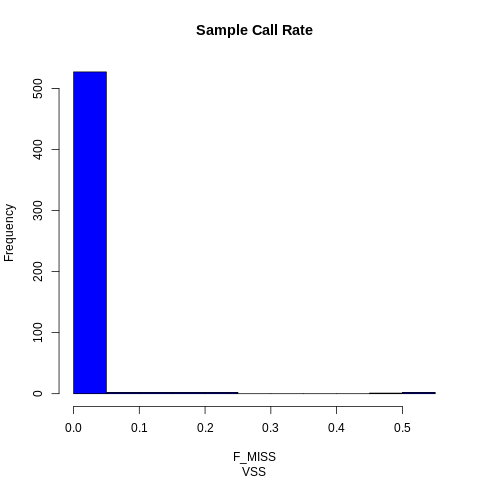

In [47]:
%%R 
#plot data 1.1

hist(imiss$F_MISS, 
     freq=TRUE, 
     col="blue", 
     border ="black", 
     main = "Sample Call Rate", 
     sub = Cohort, 
     xlab="F_MISS", 
     ylab="Frequency")

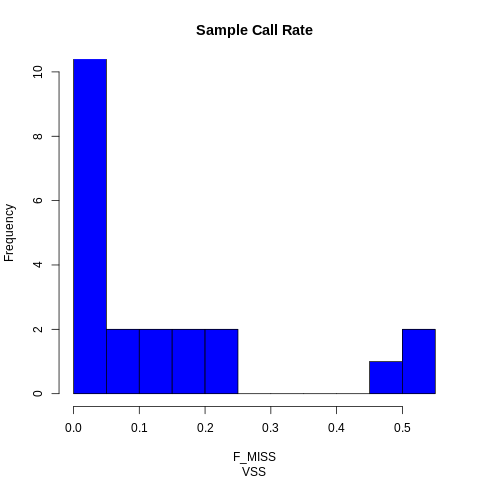

In [48]:
%%R
#plot data 1.2 - with altered axis
hist(imiss$F_MISS, 
     freq=TRUE, 
     col="blue", 
     border ="black", 
     main = "Sample Call Rate", 
     sub = Cohort, 
     xlab="F_MISS", 
     ylab="Frequency",
     ylim = c(0, 10))


Samples to be removed at less than 98% call Rate 

In [ ]:
%%R 

cr <- which(imiss$F_MISS > 0.02)  #98% call rate
# print(length(cr))

CR <- imiss[cr,]
crnumber <- dim(CR)[1]
write.table(CR, paste0(crnumber, "_", Cohort, "_", "_callrate_fails.txt"), sep="\t", col.names=TRUE, row.names=FALSE, quote=FALSE)

print(paste0("File ...", paste0(crnumber, "_", Cohort, "_", "_callrate_fail.txt"), ".. has been successfully saved"))

[1] "File ...14_VSS__callrate_fail.txt.. has been successfully saved"


In [ ]:
%%R
#Q: Can you try to plot the right number of excluded samples?
#1
hist(imiss$F_MISS, 
     freq=TRUE, 
     col="blue", 
     border ="black", 
     main = "Sample Call Rate", 
     sub = Cohort, 
     xlab="F_MISS", 
     ylab="Frequency", 
     ylim = c(0, 10), 
     breaks=100)

abline(v=0.02, lwd=2, col="firebrick", lty=2)


#2
plot(sort(imiss$F_MISS), 
     pch=20,
     main = "Sample Call Rate", 
     xlab="VSS samples", 
     ylab="F_MISS",)

abline(h=0.02, lwd=2, col="firebrick", lty=2)

#3
plot(y=rnorm(nrow(imiss)), 
     x=imiss$F_MISS, 
     pch=20, 
     main = "Sample Call Rate", 
     sub = Cohort, 
     xlab="F_MISS", 
     ylab="VSS samples")
abline(v=0.02, lwd=2, col="firebrick", lty=2)

In [ ]:
!ls #see which files are stored in your directory 

In [ ]:
%%R
# -----------------------------------------------------------------------------------------------------------------#
#          (2) SEXCHECKING - load sexcheck file                                                                    #
# -----------------------------------------------------------------------------------------------------------------#

sexcheck <- read.table("VSS-sexcheck.sexcheck", header=TRUE, fill=TRUE)

print(paste0("Dimension of sexcheck dataframe is ")); print(dim(sexcheck))
print(" -------       -------       ------")
print(paste0("Columnames of sexcheck dataframe are ")); print(names(sexcheck))
print(" -------       -------       ------")
print(paste0("First rows of sexcheck dataframe are ")); print(head(sexcheck))


In [ ]:
%%R
# -----------------------------------------------------------------------------------------------------------------#
#          (2) SEXCHECKING: load -xchr-missing.imiss file                                                          #
# -----------------------------------------------------------------------------------------------------------------#

xchr_imiss<-read.table("VSS-xchr-missing.imiss", header=TRUE, fill=TRUE)

print(paste0("Dimension of xchr_imiss dataframe is ")); print(dim(xchr_imiss))
print(" -------       -------       ------")
print(paste0("Columnames of xchr_imiss dataframe are ")); print(names(xchr_imiss))
print(" -------       -------       ------")
print(paste0("First rows of xchr_imiss dataframe are ")); print(head(xchr_imiss))


In [ ]:
%%R
# -----------------------------------------------------------------------------------------------------------------#
#          (2) SEXCHECKING : make a custom dataframe                                                               #
# -----------------------------------------------------------------------------------------------------------------#

sexcheck_imiss <- data.frame(FID=sexcheck$FID,
                             IID=sexcheck$IID, 
                             PEDSEX=sexcheck$PEDSEX, 
                             SNPSEX=sexcheck$SNPSEX, 
                             STATUS=sexcheck$STATUS, 
                             F_inbreed=sexcheck$F, 
                             F_MISS=xchr_imiss$F_MISS)

print(names(sexcheck_imiss)); print(dim(sexcheck_imiss)); print(head(sexcheck_imiss))


In [ ]:
%%R
# -----------------------------------------------------------------------------------------------------------------#
#          (2) SEXCHECKING - plotting                                                                              #
# -----------------------------------------------------------------------------------------------------------------#

plot(sexcheck_imiss$F_inbreed, 
     xchr_imiss$F_MISS, 
     col="grey", 
     main="Sex check", 
     sub= Cohort, 
     xlab="X chr inbreeding (homozygosity) estimate F", 
     ylab="Proportion of missing SNPs for the X chr")

temp <- subset(sexcheck_imiss, sexcheck_imiss$PEDSEX=="1") #1=males
points(temp$F_inbreed, temp$F_MISS, col="Blue")

temp <- subset(sexcheck_imiss, sexcheck_imiss$PEDSEX=="2") #2=females
points(temp$F_inbreed, temp$F_MISS, col="Red")

temp <- subset(sexcheck_imiss, sexcheck_imiss$STATUS=="PROBLEM") #STATUS
points(temp$F_inbreed, temp$F_MISS, col="Yellow", pch=16,cex=0.8)

legend("bottomleft", c("Male PEDSEX","Female PEDSEX", "Problem Status"), fill=c("Blue","Red", "Yellow"))
abline(v=0.8,col=2,lty=3)
abline(v=0.2,col=2,lty=3)


In [ ]:
%%R

# save the data with status=PROBLEM
sc <- which(sexcheck_imiss$STATUS=="PROBLEM")
SC <- sexcheck_imiss[sc,c(2,3,4,5,6,7)]
scnumber <- dim(SC)[1]
write.table(SC, paste0(Cohort, "_sexcheck_fails.txt"), sep="\t", col.names=TRUE, row.names=FALSE, quote=FALSE)

print(paste0(Cohort, "_sexcheck_fails.txt", ".. has been successfully saved", " ... ", "identifying ", scnumber, " problematic cases"))


In [ ]:
%%R

# -----------------------------------------------------------------------------------------------------------------#
#      (3)    Heterozygosity   MAF≥1% and MAF<1%                                                                   #
# -----------------------------------------------------------------------------------------------------------------#

Het<-read.table("Summary-VSS-chr1-22-mafgte0.01-recode.ped", header=TRUE, fill=TRUE) 


In [ ]:
%%R
Het[1:3,]

In [ ]:
%%R

Aut_imiss<-read.table( "VSS-chr1-22-mafgte0.01-missing.imiss", header=TRUE, fill=TRUE)
Aut_imiss[1:3,]

In [ ]:
%%R 
#merge the two dfs
names(Het)[1]="FID"
Het_Aut_imiss=merge(Het, Aut_imiss, by="FID")

In [ ]:
%%R
Het_Aut_imiss[1:3,]

In [ ]:
%%R
maf <- "mafgte0.01"
Cohort="VSS"

# -----------------------------------------------------------------------------------------------------------------#
#      (3)    Heterozygosity   MAF≥1% and MAF<1%                                                                   #
# -----------------------------------------------------------------------------------------------------------------#


print(dim(Het))
print(head(Het))


hist(Het$Percent_het, 
     freq=TRUE, 
     col="green", 
     border ="black", 
     main = "Autosomal heterozygosity", 
     sub = paste(Cohort, maf, sep=" "), 
     xlab="% Heterozygosity", 
     ylab="Frequency", 
     ylim= c(0,80))


hist(Het$Percent_het, 
     freq=TRUE, 
     col="green", 
     border ="black", 
     main = "Autosomal heterozygosity", 
     sub = paste(Cohort, maf, sep=" "), 
     xlab="% Heterozygosity", 
     ylab="Frequency",
     ylim= c(0,500))




In [ ]:
%%R

# -----------------------------------------------------------------------------------------------------------------#
#      (3)    Heterozygosity : Checking to see if any samples are more than 3xSD away from the mean.               #
# -----------------------------------------------------------------------------------------------------------------#

print(summary(Het$Percent_het))

print(mean(Het$Percent_het, na.rm=T)-3*sd(Het$Percent_het, na.rm=T))
print(mean(Het$Percent_het, na.rm=T)+3*sd(Het$Percent_het, na.rm=T))

line1<-mean(Het$Percent_het, na.rm=T)-3*sd(Het$Percent_het, na.rm=T)
line2<-mean(Het$Percent_het, na.rm=T)+3*sd(Het$Percent_het, na.rm=T)

print(line2)
print(which(Het$Percent_het>line2))

print(Het$Percent_het[which(Het$Percent_het>line2)])
more_line2 <- which(Het$Percent_het>line2)
print(length(more_line2))

print(line1)

print(which(Het$Percent_het<line1))
print(Het$Percent_het[which(Het$Percent_het<line1)])

less_line1 <- which(Het$Percent_het<line1)
print(length(less_line1))





In [ ]:
%%R

# -----------------------------------------------------------------------------------------------------------------#
#      (3)    Heterozygosity : PLOTTING 3SD samples ON THE CALLRATE/HET PLOT:                                      #
# -----------------------------------------------------------------------------------------------------------------#
Aut_imiss[1:3,]
Het_Aut_imiss[1:10,]

write.table(Het_Aut_imiss, 
            file="Het_Aut_imiss_mafgte001.txt", 
            sep="\t", col.names=TRUE, 
            row.names=FALSE, 
            quote=FALSE)


In [ ]:
%%R 

# -----------------------------------------------------------------------------------------------------------------#
#      (4)   DUPLICATES - RELATEDNESS                                  
# -----------------------------------------------------------------------------------------------------------------#

maf <- "mafgte0.01"
Cohort <- "VSS"
r_file=paste0("tab-", Cohort, "-chr1-22-", maf, "-noCR-LDpruned0.2-genome.genome")
genome<-read.table(paste0(r_file), sep = "\t", header=TRUE, fill=TRUE)


> reminder for pi-hat values...

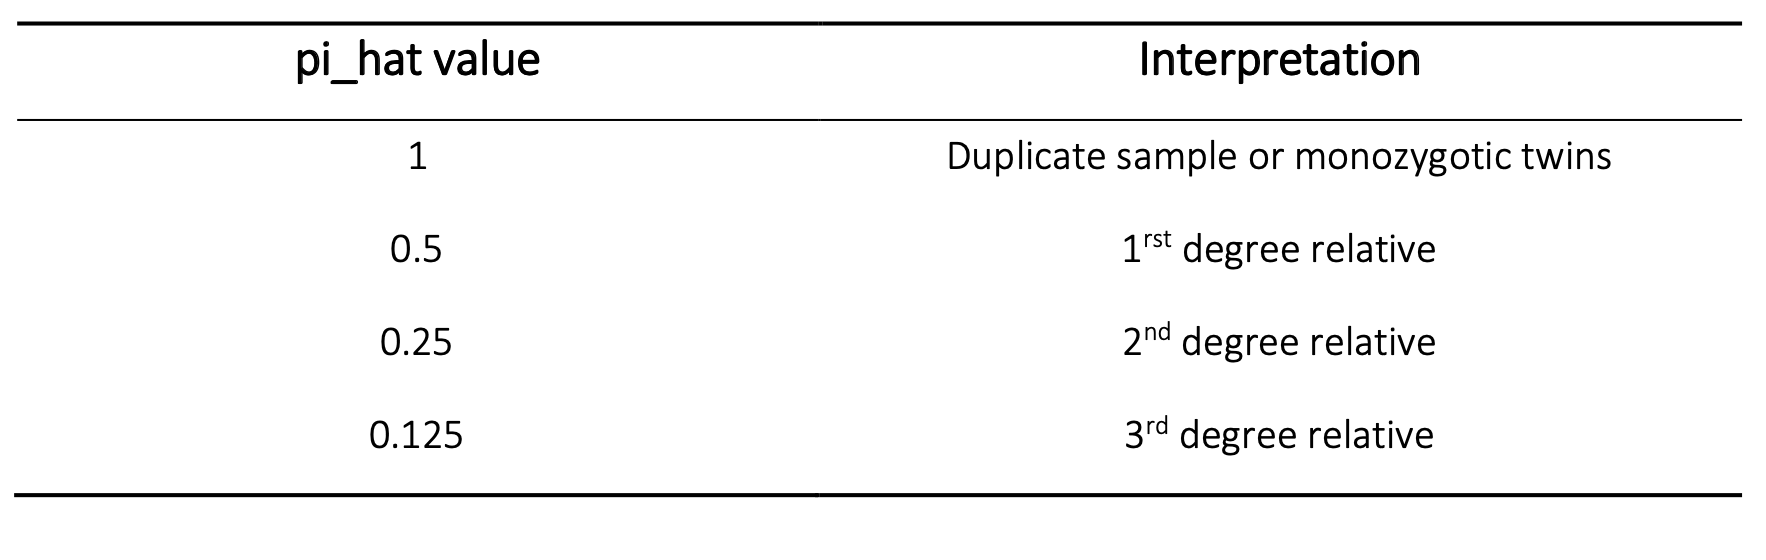

In [ ]:
%%R
print(paste0("Dimesions of genome dataframe is .. ", dim(genome)[1], " rows and ", dim(genome)[2], " columns, having the following column names:")); names(genome)
print(genome[1:3,]); print(summary(genome$PI_HAT))


In [ ]:
%%R
#Plotting the PIHATs in rank order

sorted_PI_HAT <- sort(genome$PI_HAT)
plot(sorted_PI_HAT, main= file, xlab= "rank order of PI_HAT", ylab = "PI_HAT")
abline(h=0.2,col=2,lty=3)


In [ ]:
%%R

#subsetting out the duplicates (PH_HAT > 0.9)
w_PiHat_above_thresh <- which(genome$PI_HAT > 0.9)
print(length(w_PiHat_above_thresh));print(head(w_PiHat_above_thresh))

PiHat_above_thresh <- genome[w_PiHat_above_thresh,]
dupnumber <- dim(PiHat_above_thresh)[1]


In [ ]:
%%R

# With the duplicates excluded (PI_HAT>0.9) what is the range for the remaining comparisons?
PiHat_below_thresh <- genome[-w_PiHat_above_thresh,]

print(range(PiHat_below_thresh$PI_HAT)) # taking min and max values


[1] 0.0000 0.6852


In [ ]:
%%R
#Numbering the duplicate pairs and writing the file out for excel:
PiHat_above_thresh$Dup <- (1:nrow(PiHat_above_thresh))

# export file
write.table(PiHat_above_thresh, 
            file=paste0(dupnumber, "_", Cohort,  "_PI_HATmore0.9.txt"), 
            sep="\t", 
            col.names=TRUE, 
            row.names=FALSE, 
            quote=FALSE)


In [ ]:
%%R
#subsetting out the duplicates (PH_HAT > 0.2)
wPiHat_more_point_two <- which(genome$PI_HAT > 0.2)

#print(length(wPiHat_more_point_two)); print(head(wPiHat_more_point_two))


PiHat_more_point_two <- genome[wPiHat_more_point_two,]
dupnumber <- dim(PiHat_more_point_two)[1]

PiHatless_more_point_two <- genome[-wPiHat_more_point_two,]
print(range(PiHatless_more_point_two$PI_HAT))

PiHat_more_point_two$Dup <- (1:nrow(PiHat_more_point_two))

# export file
write.table(PiHat_more_point_two, 
            file=paste0(dupnumber, "_", Cohort,  "_PI_HAT_more_point_two"), 
            sep="\t", 
            col.names=T, 
            row.names=F, 
            quote=F)




## ETHNICITY - Merging with 1000 genomes file          

In [ ]:
%%R
# -----------------------------------------------------------------------------------------------------------------#
#      (5)   ETHNICITY           Merged with 1000 genomes file                                                     #
# -----------------------------------------------------------------------------------------------------------------#

Cohort <- "VSS-1Kg"
r_file <- "VSS-1Kg-chr1-22-mafgte0.01-noCR-LDpruned0.2-genome-mds.mds"
genome <- read.table(paste(r_file), header=TRUE, fill=T)

print(genome[1:3,]); dim(genome) # 1630 individuals and 10 principal components (PCAs)

In [ ]:
%%R
# Read Reference dataset information

pop_info <- read.table(paste("Populationfile-1kg.txt", sep="/"), 
                       sep="\t", 
                       header=TRUE, fill=T)

# see what pop info has:
print(pop_info[1:3,]); table(pop_info$Population)

In [ ]:
%%R 

# Merge the Reference Dataset with the real data:
genome_popinfo <- merge(genome, pop_info, by.x = "FID", by.y = "ID", all.x = TRUE)

print(genome_popinfo[1:3,])

# export the file
write.table(genome_popinfo, 
            file="Genome_Popinfo.txt", 
            sep="\t", 
            col.names=T, 
            row.names=F, 
            quote=F)


In [ ]:
%%R
# -----------------------------------------------------------------------------------------------------------------#
#      (5)   ETHNICITY           Merged with 1000 genomes file: Plotting the                                       #
# -----------------------------------------------------------------------------------------------------------------#


Graph_title <- paste(Cohort,chip, "vs 1000genomes", sep=" ")

#Plotting C1 and C2 - subsetting by population

# that is the basic plot 
plot(genome_popinfo$C1, genome_popinfo$C2, col="white", main= Graph_title , xlab="Component 1", ylab="Component 2") #change to white for plot


# these are the additional Layers adding on top one after the other:


temp <- subset(genome_popinfo, genome_popinfo$Population=="ASW") # HapMap African ancestry individuals from SW US
points(temp$C1, temp$C2, col="darkolivegreen3", pch=2)

temp <- subset(genome_popinfo, genome_popinfo$Population=="LWK") # (LWK) Luhya individuals
points(temp$C1, temp$C2, col="forestgreen")

temp <- subset(genome_popinfo, genome_popinfo$Population=="YRI") # (YRI) Yoruba individuals
points(temp$C1, temp$C2, col="chartreuse3")

temp <- subset(genome_popinfo, genome_popinfo$Population=="CHB") # (CHB) Han Chinese in Beijing
points(temp$C1, temp$C2, col="darkblue")

temp <- subset(genome_popinfo, genome_popinfo$Population=="CHS")# (CHS) Han Chinese South
points(temp$C1, temp$C2, col="deepskyblue")

temp <- subset(genome_popinfo, genome_popinfo$Population=="JPT")# JPT Japanese individuals
points(temp$C1, temp$C2, col="darkslategray1")

temp <- subset(genome_popinfo, genome_popinfo$Population=="CLM")# Colombian in Medellin, Colombia
points(temp$C1, temp$C2, col="mediumpurple4")

temp <- subset(genome_popinfo, genome_popinfo$Population=="PUR")# Puerto Rican in Puerto Rico
points(temp$C1, temp$C2, col="mediumpurple1")

temp <- subset(genome_popinfo, genome_popinfo$Population=="MXL")# HapMap Mexican individuals from LA California
points(temp$C1, temp$C2, col="mediumorchid1")

temp <- subset(genome_popinfo, genome_popinfo$Population=="CEU")# CEPH individuals
points(temp$C1, temp$C2, col="mediumvioletred")

temp <- subset(genome_popinfo, genome_popinfo$Population=="TSI")# Toscan individuals
points(temp$C1, temp$C2, col="yellow")

temp <- subset(genome_popinfo, genome_popinfo$Population=="FIN")# HapMap Finnish individuals from Finland
points(temp$C1, temp$C2, col="pink1")

temp <- subset(genome_popinfo, genome_popinfo$Population=="IBS")# Iberian populations in Spain
points(temp$C1, temp$C2, col="orange")

temp <- subset(genome_popinfo, genome_popinfo$Population=="GBR")# British individuals from England and Scotland (GBR)
points(temp$C1, temp$C2, col="lightsalmon3")

temp <- subset(genome_popinfo, genome_popinfo$Population=="VSS")#data = VSS samples
points(temp$C1, temp$C2, col="red", pch=16, cex=0.4)


legend("topleft", c("ASW","LWK","YRI","CHB","CHS","JPT","CLM","PUR","MXL","CEU","TSI","FIN","IBS","GBR","VSS"), 
       pch=c(2,1,1,1,1,1,1,1,1,1,1,1,1,1,16), 
       col=c("darkolivegreen3","forestgreen","chartreuse3","darkblue","deepskyblue","darkslategray1","mediumpurple4","mediumpurple1",
             "mediumorchid1","mediumvioletred","yellow","pink1","orange","lightsalmon3","red"))


In [ ]:
%%R

# ---------------------------------------------------------------------------------------------------------------------------#
#      TASK: Identify the outliers, remove them from the population file (Populationfile-1kg_rmoutliers.txt) and plot again  #
# ---------------------------------------------------------------------------------------------------------------------------#

# Tip: Can you do this by using this file  Populationfile-1kg_rmoutliers.txt



















In [ ]:
#@title Solution
%%R
# SOLUTION
pop_info <- read.table(paste("Populationfile-1kg_rmoutliers.txt", sep="/"), sep="\t", header=TRUE, fill=T)
genome_popinfo <- merge(genome, pop_info, by.x = "FID", by.y = "ID", all.x = TRUE)

plot(genome_popinfo$C1, genome_popinfo$C2, col="white", main= Graph_title , xlab="Component 1", ylab="Component 2") #change to white for plot
temp <- subset(genome_popinfo, genome_popinfo$Population=="ASW") # HapMap African ancestry individuals from SW US
points(temp$C1, temp$C2, col="darkolivegreen3", pch=2)
temp <- subset(genome_popinfo, genome_popinfo$Population=="LWK") # (LWK) Luhya individuals
points(temp$C1, temp$C2, col="forestgreen")
temp <- subset(genome_popinfo, genome_popinfo$Population=="YRI") # (YRI) Yoruba individuals
points(temp$C1, temp$C2, col="chartreuse3")
temp <- subset(genome_popinfo, genome_popinfo$Population=="CHB") # (CHB) Han Chinese in Beijing
points(temp$C1, temp$C2, col="darkblue")
temp <- subset(genome_popinfo, genome_popinfo$Population=="CHS")# (CHS) Han Chinese South
points(temp$C1, temp$C2, col="deepskyblue")
temp <- subset(genome_popinfo, genome_popinfo$Population=="JPT")# JPT Japanese individuals
points(temp$C1, temp$C2, col="darkslategray1")
temp <- subset(genome_popinfo, genome_popinfo$Population=="CLM")# Colombian in Medellin, Colombia
points(temp$C1, temp$C2, col="mediumpurple4")
temp <- subset(genome_popinfo, genome_popinfo$Population=="PUR")# Puerto Rican in Puerto Rico
points(temp$C1, temp$C2, col="mediumpurple1")
temp <- subset(genome_popinfo, genome_popinfo$Population=="MXL")# HapMap Mexican individuals from LA California
points(temp$C1, temp$C2, col="mediumorchid1")
temp <- subset(genome_popinfo, genome_popinfo$Population=="CEU")# CEPH individuals
points(temp$C1, temp$C2, col="mediumvioletred")
temp <- subset(genome_popinfo, genome_popinfo$Population=="TSI")# Toscan individuals
points(temp$C1, temp$C2, col="yellow")
temp <- subset(genome_popinfo, genome_popinfo$Population=="FIN")# HapMap Finnish individuals from Finland
points(temp$C1, temp$C2, col="pink1")
temp <- subset(genome_popinfo, genome_popinfo$Population=="IBS")# Iberian populations in Spain
points(temp$C1, temp$C2, col="orange")
temp <- subset(genome_popinfo, genome_popinfo$Population=="GBR")# British individuals from England and Scotland (GBR)
points(temp$C1, temp$C2, col="lightsalmon3")
temp <- subset(genome_popinfo, genome_popinfo$Population=="VSS")#data = VSS samples
points(temp$C1, temp$C2, col="red", pch=16, cex=0.4)
legend("topleft", c("ASW","LWK","YRI","CHB","CHS","JPT","CLM","PUR","MXL","CEU","TSI","FIN","IBS","GBR","VSS"), pch=c(2,1,1,1,1,1,1,1,1,1,1,1,1,1,16), col=c("darkolivegreen3","forestgreen","chartreuse3","darkblue","deepskyblue","darkslategray1","mediumpurple4","mediumpurple1","mediumorchid1","mediumvioletred","yellow","pink1","orange","lightsalmon3","red"))


In [ ]:

# Last step: Combine all outliers' files and exclude them from your data

!./plink --bfile VSS --remove Final_exclusionlist.txt --make-bed --out VSS_sampleQCed


# Variant QC
Variant QC

It consists of (at least) four steps:

- Identification of variants with an excessive missing genotype
- Identification of variants demonstrating a significant deviation from Hardy-Weinberg equilibrium (HWE)
- Removal of all makers with a very low minor allele frequency
- Removal of all makers with cluster separation score $<0.4$


________________

The criteria used to filter out low quality markers differ from study to study Variant QC must be done with great care as every removed marker is potentially a missed disease variant Imputation can be used to recover some of the excluded markers

Here we are using the following thresholds:

> $Call \ Rate < 98$% 


> $Hwe = p <=1x10-4$

> $MAF = 1$ % 

> Cluster separation score $<=0.4$



In [ ]:
# ---------------------------------------------------------------------------------------------------------------------------#
#      TASK: Q: Can you run the plink command for all these thresholds:                                                      #
# ---------------------------------------------------------------------------------------------------------------------------#
# Tip: Samples with cluster seperation score<=0.4 are saved into a filename called cluster_sep_scr_to-exclude.txt





In [ ]:
#@title Solution

!./plink --bfile VSS_sampleQCed --geno 0.02 --hwe 0.0001 --exclude cluster_sep_scr_to-exclude.txt --maf 0.01 --make-bed --out VSS_sampleQCed_variantQCed


## Resources & References:

- [A tutorial on conducting genome‐wide association studies: Quality control and statistical analysis](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6001694/)

- [The International HapMap Project](https://pubmed.ncbi.nlm.nih.gov/14685227/)

- [An integrated map of genetic variation from 1,092 human genomes](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3498066/)


- [Genomics Boot Camp](https://genomicsbootcamp.github.io/book/)
